# View measurement color code

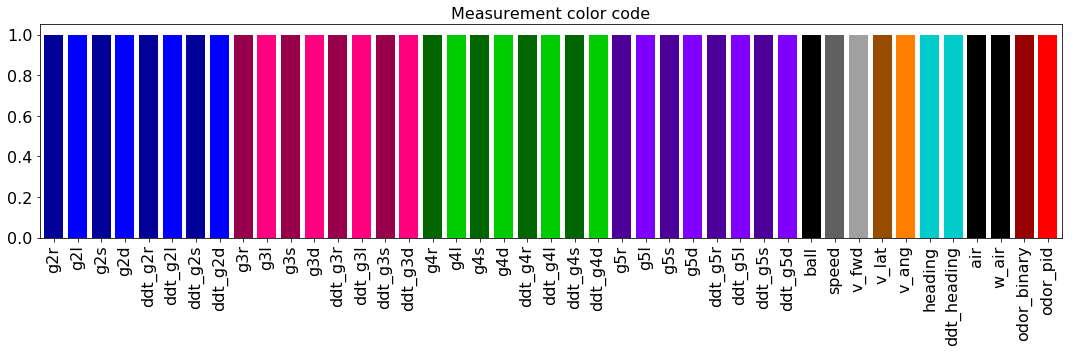

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from plot import set_font_size

import CONFIG as C


fig, ax = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)

labels = []

for x, key in enumerate(C.COLORS_RGB.keys()):
    
    color = np.array(C.COLORS_RGB[key]) / 255
    
    ax.bar([x], [1], color=color, align='center', lw=0)
    
    labels.append(key)
    
x_ticks = np.arange(len(labels))

ax.set_xlim(-0.6, len(labels) - 0.4)

ax.set_xticks(x_ticks)
ax.set_xticklabels(labels, rotation=90)

ax.set_title('Measurement color code')

set_font_size(ax, 16)

# Take snapshots of time-series for each file and save them to disk

In [2]:
%reset -f
from datetime import datetime
import gc
import os
import matplotlib.pyplot as plt
import numpy as np

from data import DataLoader, find_segs
from db import make_session, d_models
from plot import shade, set_font_size

import CONFIG as C


SAVE_DIR = 'data_snapshots'
F_TRIAL_IDX = 'js_viewer/trials.js'

AX_W = 60
AX_H = 3

GS = ['g2', 'g3', 'g4', 'g5']

## Specify snapshots

In [3]:
SNAPSHOTS = [
    ('g_r_l', [(g + 'r', g + 'l') for g in GS]),
    ('g_s_d', [(g + 's',) for g in GS] + [(g + 'd',) for g in GS]),
    
    ('ddt_g_r_l', [('ddt_' + g + 'r', 'ddt_' + g + 'l') for g in GS]),
    ('ddt_g_s_d', [('ddt_' + g + 's',) for g in GS] + [('ddt_' + g + 'd',) for g in GS]),
    
    ('paired_g_r', [
        ('g2r', 'g3r'), ('g2r', 'g4r'), ('g2r', 'g5r'), ('g3r', 'g4r'), ('g3r', 'g5r'), ('g4r', 'g5r')
    ]),
    
    ('paired_g_s', [
        ('g2s', 'g3s'), ('g2s', 'g4s'), ('g2s', 'g5s'), ('g3s', 'g4s'), ('g3s', 'g5s'), ('g4s', 'g5s')
    ]),
    
    ('paired_g_d', [
        ('g2d', 'g3d'), ('g2d', 'g4d'), ('g2d', 'g5d'), ('g3d', 'g4d'), ('g3d', 'g5d'), ('g4d', 'g5d')
    ]),
    
    ('paired_ddt_g_r', [
        ('ddt_g2r', 'ddt_g3r'), ('ddt_g2r', 'ddt_g4r'), ('ddt_g2r', 'ddt_g5r'),
        ('ddt_g3r', 'ddt_g4r'), ('ddt_g3r', 'ddt_g5r'), ('ddt_g4r', 'ddt_g5r')
    ]),
    
    ('paired_ddt_g_s', [
        ('ddt_g2s', 'ddt_g3s'), ('ddt_g2s', 'ddt_g4s'), ('ddt_g2s', 'ddt_g5s'),
        ('ddt_g3s', 'ddt_g4s'), ('ddt_g3s', 'ddt_g5s'), ('ddt_g4s', 'ddt_g5s')
    ]),
    
    ('paired_ddt_g_d', [
        ('ddt_g2d', 'ddt_g3d'), ('ddt_g2d', 'ddt_g4d'), ('ddt_g2d', 'ddt_g5d'),
        ('ddt_g3d', 'ddt_g4d'), ('ddt_g3d', 'ddt_g5d'), ('ddt_g4d', 'ddt_g5d')
    ]),
    
    ('vs_air_odor_pid', [
        ('ball',), ('speed',), ('v_fwd',), ('v_lat',), ('v_ang',),
        ('air',), ('w_air',), ('odor_binary', 'odor_pid'),
    ]),
    
    ('vs_air', [
        ('ball', 'air'), ('v_fwd', 'air'), ('v_ang', 'air'),
        ('ball', 'w_air'), ('v_fwd', 'w_air'), ('v_ang', 'w_air'),
    ]),
    
    ('vs_odor', [
        ('ball', 'odor_binary'), ('v_fwd', 'odor_binary'), ('v_ang', 'odor_binary'),
        ('ball', 'odor_pid'), ('v_fwd', 'odor_pid'), ('v_ang', 'odor_pid'),
    ]),
    
    ('air_odor', [
        ('air', 'odor_binary'), ('air', 'odor_pid'),
        ('w_air', 'odor_binary'), ('w_air', 'odor_pid'),
    ]),
    
    ('ball_g_r_l', [('ball', g + 'r') for g in GS] + [('ball', g + 'l') for g in GS]),
    ('ball_g_s_d', [('ball', g + 's') for g in GS] + [('ball', g + 'd') for g in GS]),
    
    ('ball_ddt_g_r_l',
        [('ball', 'ddt_' + g + 'r') for g in GS] + [('ball', 'ddt_' + g + 'l') for g in GS]),
    ('ball_ddt_g_s_d',
        [('ball', 'ddt_' + g + 's') for g in GS] + [('ball', 'ddt_' + g + 'd') for g in GS]),
    
    ('v_fwd_g_r_l', [('v_fwd', g + 'r') for g in GS] + [('v_fwd', g + 'l') for g in GS]),
    ('v_fwd_g_s_d', [('v_fwd', g + 's') for g in GS] + [('v_fwd', g + 'd') for g in GS]),
    
    ('v_fwd_ddt_g_r_l',
        [('v_fwd', 'ddt_' + g + 'r') for g in GS] + [('v_fwd', 'ddt_' + g + 'l') for g in GS]),
    ('v_fwd_ddt_g_s_d',
        [('v_fwd', 'ddt_' + g + 's') for g in GS] + [('v_fwd', 'ddt_' + g + 'd') for g in GS]),
    
    ('v_ang_g_r_l', [('v_ang', g + 'r') for g in GS] + [('v_ang', g + 'l') for g in GS]),
    ('v_ang_g_s_d', [('v_ang', g + 's') for g in GS] + [('v_ang', g + 'd') for g in GS]),
    
    ('v_ang_ddt_g_r_l',
        [('v_ang', 'ddt_' + g + 'r') for g in GS] + [('v_ang', 'ddt_' + g + 'l') for g in GS]),
    ('v_ang_ddt_g_s_d',
        [('v_ang', 'ddt_' + g + 's') for g in GS] + [('v_ang', 'ddt_' + g + 'd') for g in GS]),
    
    ('w_air_g_r_l', [('w_air', g + 'r') for g in GS] + [('w_air', g + 'l') for g in GS]),
    ('w_air_g_s_d', [('w_air', g + 's') for g in GS] + [('w_air', g + 'd') for g in GS]),
    
    ('w_air_ddt_g_r_l',
        [('w_air', 'ddt_' + g + 'r') for g in GS] + [('w_air', 'ddt_' + g + 'l') for g in GS]),
    ('w_air_ddt_g_s_d',
        [('w_air', 'ddt_' + g + 's') for g in GS] + [('w_air', 'ddt_' + g + 'd') for g in GS]),
    
    ('odor_binary_g_r_l', [('odor_binary', g + 'r') for g in GS] + [('odor_binary', g + 'l') for g in GS]),
    ('odor_binary_g_s_d', [('odor_binary', g + 's') for g in GS] + [('odor_binary', g + 'd') for g in GS]),
    
    ('odor_binary_ddt_g_r_l',
        [('odor_binary', 'ddt_' + g + 'r') for g in GS] + [('odor_binary', 'ddt_' + g + 'l') for g in GS]),
    ('odor_binary_ddt_g_s_d',
        [('odor_binary', 'ddt_' + g + 's') for g in GS] + [('odor_binary', 'ddt_' + g + 'd') for g in GS]),
    
    ('odor_pid_g_r_l', [('odor_pid', g + 'r') for g in GS] + [('odor_pid', g + 'l') for g in GS]),
    ('odor_pid_g_s_d', [('odor_pid', g + 's') for g in GS] + [('odor_pid', g + 'd') for g in GS]),
    
    ('odor_pid_ddt_g_r_l',
        [('odor_pid', 'ddt_' + g + 'r') for g in GS] + [('odor_pid', 'ddt_' + g + 'l') for g in GS]),
    ('odor_pid_ddt_g_s_d',
        [('odor_pid', 'ddt_' + g + 's') for g in GS] + [('odor_pid', 'ddt_' + g + 'd') for g in GS]),
]

## Verify snapshots

In [4]:
for key, snapshot in SNAPSHOTS:
    
    print('{}:'.format(key))
    
    for snapshot_ in snapshot:
        print('  {}'.format(snapshot_))
    
    print('')

g_r_l:
  ('g2r', 'g2l')
  ('g3r', 'g3l')
  ('g4r', 'g4l')
  ('g5r', 'g5l')

g_s_d:
  ('g2s',)
  ('g3s',)
  ('g4s',)
  ('g5s',)
  ('g2d',)
  ('g3d',)
  ('g4d',)
  ('g5d',)

ddt_g_r_l:
  ('ddt_g2r', 'ddt_g2l')
  ('ddt_g3r', 'ddt_g3l')
  ('ddt_g4r', 'ddt_g4l')
  ('ddt_g5r', 'ddt_g5l')

ddt_g_s_d:
  ('ddt_g2s',)
  ('ddt_g3s',)
  ('ddt_g4s',)
  ('ddt_g5s',)
  ('ddt_g2d',)
  ('ddt_g3d',)
  ('ddt_g4d',)
  ('ddt_g5d',)

paired_g_r:
  ('g2r', 'g3r')
  ('g2r', 'g4r')
  ('g2r', 'g5r')
  ('g3r', 'g4r')
  ('g3r', 'g5r')
  ('g4r', 'g5r')

paired_g_s:
  ('g2s', 'g3s')
  ('g2s', 'g4s')
  ('g2s', 'g5s')
  ('g3s', 'g4s')
  ('g3s', 'g5s')
  ('g4s', 'g5s')

paired_g_d:
  ('g2d', 'g3d')
  ('g2d', 'g4d')
  ('g2d', 'g5d')
  ('g3d', 'g4d')
  ('g3d', 'g5d')
  ('g4d', 'g5d')

paired_ddt_g_r:
  ('ddt_g2r', 'ddt_g3r')
  ('ddt_g2r', 'ddt_g4r')
  ('ddt_g2r', 'ddt_g5r')
  ('ddt_g3r', 'ddt_g4r')
  ('ddt_g3r', 'ddt_g5r')
  ('ddt_g4r', 'ddt_g5r')

paired_ddt_g_s:
  ('ddt_g2s', 'ddt_g3s')
  ('ddt_g2s', 'ddt_g4s')
  ('dd

## Load trials

In [5]:
session = make_session()
trials = session.query(d_models.Trial).order_by(d_models.Trial.name).all()
session.close()

for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx=0, vel_filt=None)

Loading data for trial 1/333 (20160118.Fly1.2)
Loading data for trial 2/333 (20160118.Fly1.3)
Loading data for trial 3/333 (20160118.Fly1.4)
Loading data for trial 4/333 (20160118.Fly1.6)
Loading data for trial 5/333 (20160118.Fly1.7)
Loading data for trial 6/333 (20160118.Fly1.8)
Loading data for trial 7/333 (20160118.Fly2.1)
Loading data for trial 8/333 (20160118.Fly2.2)
Loading data for trial 9/333 (20160118.Fly2.3)
Loading data for trial 10/333 (20160118.Fly2.4)
Loading data for trial 11/333 (20160118.Fly2.5)
Loading data for trial 12/333 (20160118.Fly2.6)
Loading data for trial 13/333 (20160118.Fly2.7)
Loading data for trial 14/333 (20160118.Fly4.1)
Loading data for trial 15/333 (20160118.Fly4.2)
Loading data for trial 16/333 (20160118.Fly4.3)
Loading data for trial 17/333 (20160118.Fly4.4)
Loading data for trial 18/333 (20160118.Fly4.5)
Loading data for trial 19/333 (20160118.Fly4.6)
Loading data for trial 20/333 (20160118.Fly4.7)
Loading data for trial 21/333 (20160118.Fly4.8)
L

Loading data for trial 173/333 (20160905.Fly4.3)
Loading data for trial 174/333 (20160905.Fly4.4)
Loading data for trial 175/333 (20160905.Fly4.5)
Loading data for trial 176/333 (20160905.Fly4.6)
Loading data for trial 177/333 (20160905.Fly4.7)
Loading data for trial 178/333 (20160905.Fly5.1)
Loading data for trial 179/333 (20160905.Fly5.2)
Loading data for trial 180/333 (20160905.Fly5.4)
Loading data for trial 181/333 (20160905.Fly6.1)
Loading data for trial 182/333 (20160905.Fly6.2)
Loading data for trial 183/333 (20160905.Fly6.3)
Loading data for trial 184/333 (20160905.Fly6.4)
Loading data for trial 185/333 (20160905.Fly7.1)
Loading data for trial 186/333 (20160905.Fly7.2)
Loading data for trial 187/333 (20160905.Fly7.3)
Loading data for trial 188/333 (20160905.Fly7.4)
Loading data for trial 189/333 (20160905.Fly7.5)
Loading data for trial 190/333 (20160905.Fly8.1)
Loading data for trial 191/333 (20160905.Fly8.2)
Loading data for trial 192/333 (20160905.Fly8.3)
Loading data for tri

## Write index file

In [6]:
# make all snapshot directories
trial_keys = []
trial_paths = []
trial_paths_dict = {}

for trial in trials:
    trial_key = '{} ({})'.format(trial.name, trial.expt)
    trial_path = os.path.join(SAVE_DIR, trial.fly, trial_key)
    
    if not os.path.exists(trial_path):
        os.makedirs(trial_path)
        
    trial_keys.append(trial_key)
    trial_paths.append(trial_path)
    trial_paths_dict[trial.name] = trial_path

In [7]:
# open file
with open(F_TRIAL_IDX, 'w') as f:
    f.write('var trials = {};\n')
    
    for tk, tp in zip(trial_keys, trial_paths):
        f.write('trials["{}"] = "{}";\n'.format(tk, tp))
        
    f.write('\n')
    f.write('var plot_types = [\n')
    
    for snapshot in SNAPSHOTS:
        f.write('  "{}",\n'.format(snapshot[0]))
    f.write(']\n')

## Define snapshot-to-PNG function

In [8]:
def save_snapshot(
    save_file, trial, variables, ax_w=AX_W, ax_h=AX_H, lw=2, shading=None):
    """
    Save the complete time-series data for several quantities for
    a trial to a single PNG image for efficient viewing.
    
    :param variables: list of lists/tuples of variables
    :param shading: shading to apply on top of time-series traces; dict
        where keys are rgbas and vals are segments to shade
    """
    if shading is None:
        shading == {}
    
    # make sure each element of variables is a list of variables
    variables = [vs if hasattr(vs, '__iter__') else [vs] for vs in variables]
    
    if any([len(vs) > 2 for vs in variables]):
        assert NotImplementedError('Sets of more than 2 variables not implemented yet.')
        
    # make sure save directory exists
    save_dir = os.path.dirname(save_file)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    # get quantities from trial
    t = trial.dl.t
    vs_unique = list(set(sum(variables, ())))
     
    data = {v: getattr(trial.dl, v) for v in vs_unique}
    colors = {
        v: (np.array(C.COLORS_RGB[v])/255 if v in C.COLORS_RGB else 'gray')
        for v in vs_unique
    }
    
    # arrange figure
    fig_size = (ax_w, ax_h*len(variables))
    fig, axs = plt.subplots(
        len(variables), 1, figsize=fig_size, tight_layout=True, squeeze=False)
    
    for ax, vs in zip(axs[:, 0], variables):

        handles = [ax.plot(t, data[vs[0]], color=colors[vs[0]], lw=lw, label=vs[0])[0]]
        
        if shading is not None:
            for rgba, segs in shading.items():
                shade(ax, segs, rgba)
        
        
        
        if len(vs) == 2:
            
            ax_twin = ax.twinx()

            handles.append(ax_twin.plot(t, data[vs[1]], color=colors[vs[1]], lw=lw, label=vs[1])[0])

            ax_twin.set_xlim(t[0], t[-1])
            ax_twin.set_ylabel(vs[1], color=colors[vs[1]])
            
            set_font_size(ax_twin, 16)
        
        ax.set_xlim(t[0], t[-1])
        
        ax.grid()
        
        ax.set_xlabel('t (s)')
        ax.set_ylabel(vs[0], color=colors[vs[0]])
        ax.set_title(', '.join(vs))
        
        ax.legend(handles=handles, loc='upper left')
        
        set_font_size(ax, 16)

    # save png
    fig.savefig(save_file)
    plt.close('all')
    
    data = None
    fig = None
    
    return save_file

## Loop over trials and snapshots

In [9]:
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.expt.in_(['closed_odor_fluct', 'white_odor_fluct'])).order_by(d_models.Trial.name).all()
session.close()

In [10]:
for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx=0, vel_filt=None)

for trial in trials[32:]:
    
    print('Taking snapshots of trial "{}"...'.format(trial.name))
    print('  ({})'.format(datetime.strftime(datetime.now(), '%Y-%m-%d %H:%M:%S')))
    
    for key, variables in SNAPSHOTS:
        
        # get shading if sensory trial
        if trial.expt in C.EXPTS_SENSORY:
            
            segs = find_segs(trial.dl.odor_binary == 1)
            segs_t = [(trial.dl.t[seg[0]], trial.dl.t[seg[1]-1] + C.DT) for seg in segs]
            
            shading = {(0.85, 0.85, 0.85): segs_t}
            
        else:
            shading = None
        
        save_file = os.path.join(trial_paths_dict[trial.name], '{}.png'.format(key))
        save_snapshot(save_file, trial, variables, ax_w=AX_W, ax_h=AX_H, lw=2, shading=shading)
            
        gc.collect()

Loading data for trial 1/34 (20171130.Fly1.1)
Loading data for trial 2/34 (20171130.Fly1.2)
Loading data for trial 3/34 (20171130.Fly1.3)
Loading data for trial 4/34 (20171130.Fly1.4)
Loading data for trial 5/34 (20171130.Fly1.5)
Loading data for trial 6/34 (20171130.Fly1.6)
Loading data for trial 7/34 (20171130.Fly2.1)
Loading data for trial 8/34 (20171130.Fly2.2)
Loading data for trial 9/34 (20171130.Fly3.1)
Loading data for trial 10/34 (20171130.Fly3.2)
Loading data for trial 11/34 (20171130.Fly3.3)
Loading data for trial 12/34 (20171130.Fly3.4)
Loading data for trial 13/34 (20171130.Fly3.5)
Loading data for trial 14/34 (20171130.Fly3.6)
Loading data for trial 15/34 (20171130.Fly3.7)
Loading data for trial 16/34 (20171130.Fly4.1)
Loading data for trial 17/34 (20171130.Fly4.2)
Loading data for trial 18/34 (20171130.Fly4.3)
Loading data for trial 19/34 (20171130.Fly4.4)
Loading data for trial 20/34 (20171130.Fly4.5)
Loading data for trial 21/34 (20171130.Fly4.6)
Loading data for trial